In [1]:
import pickle
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import scale

#from keras.models import Sequential
#from keras.optimizers import SGD, Adam, Adagrad
#from keras import backend as K
#from keras.layers import Embedding
#from keras.layers import Dense, Reshape, Concatenate, Activation, Dropout
#from keras.callbacks import ModelCheckpoint

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_cache = 'cache/train.pickle'
train_labels_cache = 'cache/train-labels.npy'
validation_cache = 'cache/validation.pickle'
validation_labels_cache = 'cache/validation-labels.npy'
test_cache = 'cache/test.pickle'
test_labels_cache = 'cache/test-labels.npy'
competition_test_cache = 'cache/competition-test.pickle'
metadata_cache = 'cache/metadata.pickle'

In [3]:
train_cache = 'cache/train2.pickle'
train_labels_cache = 'cache/train-labels2.npy'
validation_cache = 'cache/validation2.pickle'
validation_labels_cache = 'cache/validation-labels2.npy'
test_cache = 'cache/test2.pickle'
test_labels_cache = 'cache/test-labels2.npy'
competition_test_cache = 'cache/competition-test2.pickle'
metadata_cache = 'cache/metadata2.pickle'

In [4]:
train = pd.read_pickle(train_cache)
validation = pd.read_pickle(validation_cache)
test = pd.read_pickle(test_cache)

train_labels = np.load(train_labels_cache)
validation_labels = np.load(validation_labels_cache)
test_labels = np.load(test_labels_cache)

competition_test = pd.read_pickle(competition_test_cache)
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)

In [5]:
def process_features(df):
    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED','ORIGIN_STAND_ENCODED',
                           'dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
                           'dt_2014-12-21 00:00:00']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED',
#                            'ORIGIN_STAND_ENCODED']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_STAND_ENCODED','dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
#                           'dt_2014-12-21 00:00:00']].values)

In [6]:
#Two layers got 726
#Three layers also 726
#200 epochs for >=300, three layers 708: 65, 100, 40, 10, 1
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.embed_quarter_hour = nn.Embedding(metadata['n_quarter_hours'], 10)
        self.embed_day_of_week = nn.Embedding(metadata['n_days_per_week'], 10)
        self.embed_week_of_year = nn.Embedding(metadata['n_weeks_per_year'],10)
        self.embed_client_ids = nn.Embedding(metadata['n_client_ids'],10)
        self.embed_taxi_ids = nn.Embedding(metadata['n_taxi_ids'],10)
        self.embed_stand_ids = nn.Embedding(metadata['n_stand_ids'],10)
        self.layer1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=65, out_features=100),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features = 100, out_features = 40),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features = 40, out_features = 10),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        qhr = self.embed_quarter_hour(x[:,0].to(torch.int32))
        dow = self.embed_day_of_week(x[:,1].to(torch.int32))
        woy = self.embed_week_of_year(x[:,2].to(torch.int32))
        ci = self.embed_client_ids(x[:,3].to(torch.int32))
        ti = self.embed_taxi_ids(x[:,4].to(torch.int32))
        si =  self.embed_stand_ids(x[:,5].to(torch.int32))
        x = torch.cat([qhr,dow,woy,ci,ti,si,x[:,6:]],axis=1)
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

In [7]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 200

In [8]:
x=process_features(train)
x.shape

torch.Size([326542, 11])

In [9]:
train_data = process_features(train)
train_data = TensorDataset(train_data, torch.tensor(train_labels))
validate_data = process_features(validation)
validate_data = TensorDataset(validate_data,torch.tensor(validation_labels))
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validate_data, batch_size = BATCH_SIZE,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
all_losses = []
train_loss = []
validation_losses = []

In [10]:
model = MLP()
model = model.to(device)

In [11]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [12]:
def train_data(model, train_loader, val_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        validation_losses.append(val_loss/len(val_loader))
        print(f"Epoch: {epoch} Validation Loss:{val_loss/len(val_loader)}")
        PATH = f'model_state/model_epoch{epoch}.pth'     
        torch.save(model.state_dict(), PATH)

In [13]:
train_data(model, train_loader, val_loader, criterion, 200) # use the training function you defined
val_loss = validate(model, val_loader, criterion)

Epoch: 0 Training Loss:801.7981054491383
Epoch: 0 Validation Loss:630.6669221100984
Epoch: 1 Training Loss:689.129748389265
Epoch: 1 Validation Loss:619.5946044921875
Epoch: 2 Training Loss:683.628367636271
Epoch: 2 Validation Loss:617.289372196904
Epoch: 3 Training Loss:677.2616293019262
Epoch: 3 Validation Loss:621.148275869864
Epoch: 4 Training Loss:672.192961869195
Epoch: 4 Validation Loss:598.727502045808
Epoch: 5 Training Loss:668.3453046266562
Epoch: 5 Validation Loss:616.557926884404
Epoch: 6 Training Loss:666.3127026094538
Epoch: 6 Validation Loss:607.0156758626302
Epoch: 7 Training Loss:662.7960986552941
Epoch: 7 Validation Loss:611.2603058991609
Epoch: 8 Training Loss:659.9662952363304
Epoch: 8 Validation Loss:598.2479084156178
Epoch: 9 Training Loss:657.587129012918
Epoch: 9 Validation Loss:594.9961773907697
Epoch: 10 Training Loss:656.7896321694305
Epoch: 10 Validation Loss:602.7063824688947
Epoch: 11 Training Loss:654.9412922754557
Epoch: 11 Validation Loss:633.0085121437

Epoch: 96 Training Loss:607.6298543517493
Epoch: 96 Validation Loss:547.3974937156395
Epoch: 97 Training Loss:606.8331893633899
Epoch: 97 Validation Loss:552.8632631655092
Epoch: 98 Training Loss:608.0026497317706
Epoch: 98 Validation Loss:546.3004082573784
Epoch: 99 Training Loss:604.8366839728759
Epoch: 99 Validation Loss:549.2637396918403
Epoch: 100 Training Loss:605.9215080954812
Epoch: 100 Validation Loss:547.0728262442129
Epoch: 101 Training Loss:606.6460727105693
Epoch: 101 Validation Loss:543.4274913646557
Epoch: 102 Training Loss:604.6413596819934
Epoch: 102 Validation Loss:550.7182266800492
Epoch: 103 Training Loss:606.057245152871
Epoch: 103 Validation Loss:574.566897922092
Epoch: 104 Training Loss:604.6754035949707
Epoch: 104 Validation Loss:558.7145114474827
Epoch: 105 Training Loss:604.9346377333877
Epoch: 105 Validation Loss:547.4567226833767
Epoch: 106 Training Loss:603.0824857849312
Epoch: 106 Validation Loss:549.9046517831308
Epoch: 107 Training Loss:604.168085594536


Epoch: 190 Training Loss:586.969538243213
Epoch: 190 Validation Loss:527.6298720748337
Epoch: 191 Training Loss:587.3310253657518
Epoch: 191 Validation Loss:535.3552856445312
Epoch: 192 Training Loss:587.5572391737218
Epoch: 192 Validation Loss:537.0569435402199
Epoch: 193 Training Loss:586.4354661206092
Epoch: 193 Validation Loss:533.1017569082754
Epoch: 194 Training Loss:589.2396559042617
Epoch: 194 Validation Loss:523.98914831656
Epoch: 195 Training Loss:586.6408741033189
Epoch: 195 Validation Loss:529.2745700412327
Epoch: 196 Training Loss:586.2024197473795
Epoch: 196 Validation Loss:526.6894288239656
Epoch: 197 Training Loss:587.3375052090349
Epoch: 197 Validation Loss:534.7249111599392
Epoch: 198 Training Loss:586.5280290920533
Epoch: 198 Validation Loss:535.6509376808449
Epoch: 199 Training Loss:586.7340318386831
Epoch: 199 Validation Loss:535.8871674714266


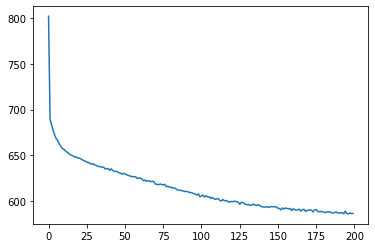

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

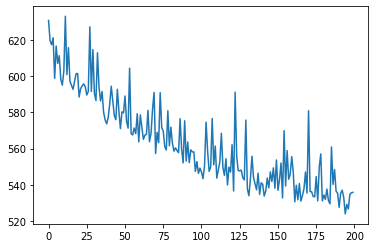

In [17]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(validation_losses)))

In [18]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [19]:
test_losses = []
for i in range(200):
    model.load_state_dict(torch.load(f'model_state/model_epoch{i}.pth'))
    test_losses.append(view_loss(model,process_features(test),torch.tensor(test_labels).to(torch.float32),criterion)/process_features(test).shape[0]*128)
    print(f"epoch: {i}, test loss: {view_loss(model, process_features(test), torch.tensor(test_labels).to(torch.float32), criterion)/process_features(test).shape[0]*128}")

epoch: 0, test loss: 664.8278198242188
epoch: 1, test loss: 679.7754516601562
epoch: 2, test loss: 724.3898315429688
epoch: 3, test loss: 635.8513793945312
epoch: 4, test loss: 638.1712036132812
epoch: 5, test loss: 635.7236938476562
epoch: 6, test loss: 637.7737426757812
epoch: 7, test loss: 669.8396606445312
epoch: 8, test loss: 642.0285034179688
epoch: 9, test loss: 643.2478637695312
epoch: 10, test loss: 637.9391479492188
epoch: 11, test loss: 632.06005859375
epoch: 12, test loss: 680.1068725585938
epoch: 13, test loss: 635.2598876953125
epoch: 14, test loss: 641.3841552734375
epoch: 15, test loss: 650.4899291992188
epoch: 16, test loss: 621.382080078125
epoch: 17, test loss: 649.7487182617188
epoch: 18, test loss: 624.2750854492188
epoch: 19, test loss: 620.476806640625
epoch: 20, test loss: 624.2627563476562
epoch: 21, test loss: 624.2876586914062
epoch: 22, test loss: 631.5840454101562
epoch: 23, test loss: 627.2842407226562
epoch: 24, test loss: 615.8500366210938
epoch: 25, tes

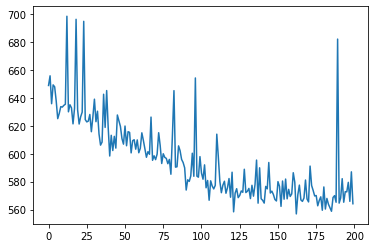

In [20]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(test_losses)))

In [21]:
print(model)

MLP(
  (embed_quarter_hour): Embedding(96, 10)
  (embed_day_of_week): Embedding(7, 10)
  (embed_week_of_year): Embedding(52, 10)
  (embed_client_ids): Embedding(20778, 10)
  (embed_taxi_ids): Embedding(440, 10)
  (embed_stand_ids): Embedding(64, 10)
  (layer1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65, out_features=100, bias=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100, out_features=40, bias=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=40, out_features=10, bias=True)
    (2): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [29]:
model.load_state_dict(torch.load('model_state/model_epoch188.pth'))

<All keys matched successfully>

In [30]:
predict_input = torch.tensor(process_features(competition_test)).to(device)
print(predict_input.shape)

torch.Size([320, 11])


/tmp/ipykernel_3815/1078090879.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict_input = torch.tensor(process_features(competition_test)).to(device)


In [31]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [32]:
out = predict(model)

In [33]:
embed_mlp_predict = pd.read_csv('test_public.csv')
embed_mlp_predict = embed_mlp_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
embed_mlp_predict= pd.concat([embed_mlp_predict, pd.DataFrame(predict_tensor)], axis=1)
embed_mlp_predict = embed_mlp_predict.rename(columns={0: 'TRAVEL_TIME'})
embed_mlp_predict[0:50]

,TRIP_ID,TRAVEL_TIME
0,T1,746.201660
1,T2,596.132812
2,T3,692.688171
3,T4,602.888550
4,T5,627.697510
5,T6,657.131165
6,T7,698.519531
7,T8,709.210144
8,T9,621.440674
9,T10,712.639160


In [34]:
embed_mlp_predict['TRAVEL_TIME'].mean()

819.0732

In [35]:
embed_mlp_predict.to_csv('Embedding_MLP_188_retrain.csv', index=False)

In [ ]:
a = process_features(train)
print(a[:,0])
embedding1 = torch.nn.Embedding(96, 10)
embedding2 = torch.nn.Embedding()
print(embedding(a[0,0].to(torch.int32)))